In [2]:
import torch
import torch.nn.functional as F
import time
import random
import math
import numpy as np
from epifit.graphing_utils import *
from epifit.transitions import *
from epifit.network_generation import *

device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(device)

cuda


In [5]:
n = 2000 # population size
pinf_default_bio = 0.05 # how likely a person infected is to infect someone else
psus_default_bio = 0.05 # how likely a person is to get infected by someone who is infective
recover_time_bio = 30 # average recover time in days
incubation_time_bio = 6.4 # average incubation time
fatality_bio = 0.025 # proportion of people who are likely to die if infected
pinf_multiplier_firstvaccine = 0.6 # those who receive the first dose of the vaccine are 0.6 times as infective
psus_multiplier_firstvaccine = 0.6
pinf_multiplier_secondvaccine = 0.2
psus_multiplier_secondvaccine = 0.2
pinf_multiplier_mask = 0.8
psus_multiplier_mask = 0.8
seeds_bio = 3
vaccine_start = 150 # day vaccine administration begins
vaccine_efficacy_proportion = 0.7 # alternate way of modeling vaccine efficacy - the proportion of people who will be immune after vaccination
pinf_provaccine_vaccination = 0.01 # how likely a provaccine person is to get vaccinated that day
max_vaccines_per_day = 10
days_between_vaccine_doses = 14

I_name_bio = "infected_covid"
R_name_bio = "remaining_recovery_time"
D_name_bio = "remaining_death_time"
E_name_bio = "remaining_incubation_time"
V_name_bio = "vaccinated"
susceptiveness_name_bio = "susceptiveness_covid"
infectiveness_name_bio = "infectiveness_covid"
recover_time_name_bio = "recovery_times"
fatality_name_bio = "fatality_times"
incubation_name_bio = "incubation_times"
vaccine_efficacy_name_bio = "vaccine_efficacy"
age_name_bio = "age"
vaccine_seconddosetime_name = "days_until_second_dose"
provaccine_name_socio = "provaccine"
promask_name_socio = "mask"

preevaluate_vaccine_socio = 0.5 # how likely a person is to reevaluate their vaccine stance
preevaluate_mask_socio = 0.5 # how likely a person is to reevaluate their mask stance
pinf_socio_biocontacts = 0.01 # how likely a contact who is infected is to convince the person to wear a mask that day
pinf_socio_bioself = 0.5 # how likely someone who is infected is to decide to wear a mask that day
provaccine_proportion_socio = 0.8 # proportion of population who is initially provaccine
promask_proportion_socio = 0.5
maxt = 500

def initializations(pinf, psus, avg_recover_time, avg_fatality, avg_incubation_time, E_name, I_name, R_name, D_name, V_name, susceptiveness_name, infectiveness_name, recover_time_name, incubation_name, fatality_name, vaccine_efficacy_name, vaccine_efficacy_proportion, age_name, time_seconddose_name, seeds=1):
    E = torch.ones(n).to(device) * math.inf
    I = torch.zeros(n).to(device)
    R = torch.ones(n).to(device) * math.inf
    D = torch.ones(n).to(device) * math.inf
    E[random.sample(range(0, n-1), seeds)] = 0
    susceptiveness = torch.ones(n).to(device)*psus
    infectiveness = torch.ones(n).to(device)*pinf
    V = torch.zeros(n).to(device)
    
    # destiny in case of infection is predetermined
    incubation = F.relu(torch.distributions.normal.Normal(avg_incubation_time,2).rsample((n,)).to(device))
    fatality = torch.where((torch.rand(n).to(device) < avg_fatality), incubation+14*torch.ones(n).to(device), math.inf*torch.ones(n).to(device))        
    recover_time = F.relu(torch.distributions.normal.Normal(avg_recover_time,2).rsample((n,)).to(device))+incubation
    vaccine_efficacy = torch.ones(n).to(device) 
    vaccine_efficacy[random.sample(range(n), int((1-vaccine_efficacy_proportion)*n))] = 0
    time_until_second_dose = torch.ones(n).to(device)*math.inf
    ages = torch.rand(n)*120
    return  {E_name: E, I_name: I, R_name: R, D_name: D, V_name: V, recover_time_name: recover_time, susceptiveness_name: susceptiveness, infectiveness_name: infectiveness, incubation_name: incubation, fatality_name: fatality, vaccine_efficacy_name: vaccine_efficacy, age_name: ages, time_seconddose_name: time_until_second_dose}            

In [6]:
# generating biological contact net
contacts_outofhome, contacts_insteadofhouseholds, ages = generate_households_contactsbyage(n)
con_bio = contacts_outofhome+contacts_insteadofhouseholds

# resetting population size based on households
n = ages.size()[0]

FileNotFoundError: [Errno 2] No such file or directory: '../data/contact_matrix.csv'

In [3]:
# generating social layer contact net
age_group_boundaries = torch.Tensor([10, 20, 30, 40, 50, 60, 70, 80, 90, 120]).to(device)
connection_by_age_group = torch.Tensor([0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]).to(device)

con_socio = generate_social_layer_from_physical(contacts_insteadofhouseholds, contacts_outofhome, ages, age_group_boundaries, connection_by_age_group, 0.5)

NameError: name 'contacts_insteadofhouseholds' is not defined

In [6]:
def sim(repeats=1):
    with torch.no_grad():
        final_log = []
        
        for _ in range(repeats):
            # states initialization
            states = initializations(pinf=pinf_default_bio, psus=psus_default_bio, avg_recover_time=recover_time_bio, avg_fatality=fatality_bio, 
                                     avg_incubation_time=incubation_time_bio, recover_time_name=recover_time_name_bio, I_name=I_name_bio, E_name=E_name_bio,
                                     R_name=R_name_bio, D_name=D_name_bio, V_name=V_name_bio, susceptiveness_name=susceptiveness_name_bio, infectiveness_name=infectiveness_name_bio, 
                                     incubation_name=incubation_name_bio, fatality_name=fatality_name_bio, vaccine_efficacy_name=vaccine_efficacy_name_bio, 
                                     vaccine_efficacy_proportion=vaccine_efficacy_proportion, age_name=age_name_bio, seeds = seeds_bio, time_seconddose_name=vaccine_seconddosetime_name) # bio states
            provaccine_socio = torch.zeros(n).to(device)
            provaccine_socio[random.sample(range(0, n), int(provaccine_proportion_socio*n))] = 1
            states[provaccine_name_socio] = provaccine_socio
            
            promask_socio = torch.zeros(n).to(device)
            promask_socio[random.sample(range(0, n), int(promask_proportion_socio*n))] = 1
            states[promask_name_socio] = promask_socio
            
            states[age_name_bio] = ages
            assert len(states) == 15 # check against duplicate names
            
            # transitions
            init_susceptiveness = InitializeValues(state_name=susceptiveness_name_bio, state_value=psus_default_bio)
            init_infectiveness = InitializeValues(state_name=infectiveness_name_bio, state_value=pinf_default_bio)
            initializing_sus_inf = torch.nn.Sequential(init_susceptiveness, init_infectiveness)
            
            # transitions between states
            se_bio = S_E(contact_net=con_bio, pinf=pinf_default_bio, E_name=E_name_bio, susceptiveness_name=susceptiveness_name_bio, infectiveness_name=infectiveness_name_bio, incubation_name=incubation_name_bio, infective_name=I_name_bio)
            ei_bio = E_I(E_name=E_name_bio,I_name=I_name_bio)
            ir_bio = I_R(I_name=I_name_bio, R_name=R_name_bio, recover_time_name=recover_time_name_bio)
            id_bio = I_D(I_name=I_name_bio, D_name=D_name_bio, fatality_name=fatality_name_bio)
            
            inf_vaccine_dose1 = ControllingState_ControlledState(controlling_state_name=V_name_bio, controlled_state_name=infectiveness_name_bio,
                                                                 controlling_state_value=1, controlled_state_value=pinf_multiplier_firstvaccine, 
                                                                 pinf=1, controlledval_is_multiplier=True)
            inf_vaccine_dose2 = ControllingState_ControlledState(controlling_state_name=V_name_bio, controlled_state_name=infectiveness_name_bio,
                                                                 controlling_state_value=2, controlled_state_value=pinf_multiplier_secondvaccine, 
                                                                 pinf=1, controlledval_is_multiplier=True)
            sus_vaccine_dose1 = ControllingState_ControlledState(controlling_state_name=V_name_bio, controlled_state_name=susceptiveness_name_bio,
                                                                 controlling_state_value=1, controlled_state_value=psus_multiplier_firstvaccine, 
                                                                 pinf=1, controlledval_is_multiplier=True)
            sus_vaccine_dose2 = ControllingState_ControlledState(controlling_state_name=V_name_bio, controlled_state_name=susceptiveness_name_bio,
                                                                 controlling_state_value=2, controlled_state_value=psus_multiplier_secondvaccine, 
                                                                 pinf=1, controlledval_is_multiplier=True)
            vis_bio = torch.nn.Sequential(inf_vaccine_dose1, sus_vaccine_dose1, inf_vaccine_dose2, sus_vaccine_dose2)
            
            seird_bio = torch.nn.Sequential(se_bio, ei_bio, ir_bio, id_bio)
            seirdv_bio = torch.nn.Sequential(vis_bio, se_bio, ei_bio, ir_bio, id_bio)
            
            symmetric_vaccine_socio = Contacts_SwitchState(preevaluate=preevaluate_vaccine_socio, contact_net=con_socio, state_name=provaccine_name_socio, active_state_name=D_name_bio)
            symmetric_mask_socio = Contacts_SwitchState(preevaluate=preevaluate_mask_socio, contact_net=con_socio, state_name=promask_name_socio, active_state_name=D_name_bio)
            symmetric_mask_socio_nonfamily = Contacts_SwitchState(preevaluate=preevaluate_mask_socio, contact_net=con_socio, state_name=promask_name_socio, active_state_name=D_name_bio)
            symmetric_mask_socio_family = Contacts_SwitchState(preevaluate=preevaluate_mask_socio*2, contact_net=contacts_insteadofhouseholds, state_name=promask_name_socio, active_state_name=D_name_bio)
            symmetric_mask_socio_family_onlyadultsinfluence = Contacts_SwitchState(preevaluate=preevaluate_mask_socio*2, contact_net=contacts_insteadofhouseholds, state_name=promask_name_socio, active_state_name=D_name_bio, requirement_forinfluencers = lambda states: (states[age_name_bio]>18)&(states[age_name_bio]<65))
            
            
            # transitions between layers
            provaccine_gettingvaccinated = ControllingState_ControlledState(controlling_state_name=provaccine_name_socio, controlled_state_name=V_name_bio, controlling_state_value=1, controlled_state_value=1, 
                                                                            pinf=pinf_provaccine_vaccination, maxcontrolled=max_vaccines_per_day, start=vaccine_start, required_initial_controlledstatevalue=0)
            setting_secondvaccine_date = ControllingState_ControlledState(controlling_state_name=V_name_bio, controlled_state_name=vaccine_seconddosetime_name,
                                                                         controlling_state_value=1, controlled_state_value=days_between_vaccine_doses,
                                                                         pinf=1, required_initial_controlledstatevalue=math.inf)
            updating_time_until_secondvaccine = Inc_Dec(state_name=vaccine_seconddosetime_name, inc=False)
            second_vaccination = ControllingState_ControlledState(controlling_state_name=vaccine_seconddosetime_name, controlled_state_name=V_name_bio,
                                                                 controlling_state_value=0, controlled_state_value=2, pinf=1)
            vaccinations = torch.nn.Sequential(provaccine_gettingvaccinated, setting_secondvaccine_date, updating_time_until_secondvaccine, second_vaccination)
            
            covidinfection_means_maskwearing = ControllingState_ControlledState(controlling_state_name=I_name_bio, controlled_state_name=promask_name_socio, controlling_state_value=1, controlled_state_value=1, pinf=pinf_socio_bioself)
            infected_contacts_leads_to_provaccine = Contacts_InfectingState(contact_net=con_socio, contacts_state_name=I_name_bio, susceptible_state_name=provaccine_name_socio, pinf=pinf_socio_biocontacts, infected_value=1)

            inf_mask = ControllingState_ControlledState(controlling_state_name=promask_name_socio, controlled_state_name=infectiveness_name_bio,
                                                                 controlling_state_value=1, controlled_state_value=pinf_multiplier_mask, 
                                                                 pinf=1, controlledval_is_multiplier=True)
            sus_mask = ControllingState_ControlledState(controlling_state_name=V_name_bio, controlled_state_name=susceptiveness_name_bio,
                                                                 controlling_state_value=1, controlled_state_value=psus_multiplier_mask, 
                                                                 pinf=1, controlledval_is_multiplier=True)
            mask_affecting_infections = torch.nn.Sequential(inf_mask, sus_mask)
            
            # two layer models
            seirdv_bio_symmetric_socio = torch.nn.Sequential(initializing_sus_inf, mask_affecting_infections, seirdv_bio, vaccinations, symmetric_vaccine_socio, symmetric_mask_socio_family_onlyadultsinfluence, symmetric_mask_socio_nonfamily, covidinfection_means_maskwearing, infected_contacts_leads_to_provaccine)
            
            log = []
            for _ in range(maxt):
                states = seirdv_bio_symmetric_socio(states)
                
                log.append(torch.stack((states[E_name_bio]==math.inf, ((states[E_name_bio] > 0)&(states[E_name_bio] < math.inf)), states[I_name_bio], ((states[R_name_bio]==0)&(states[D_name_bio]>0)).float(), (states[D_name_bio]==0).float(), (states[V_name_bio]==1).float(), (states[V_name_bio]==2), states[provaccine_name_socio], states[promask_name_socio])))
            final_log.append(torch.stack(log))
        final_log = torch.stack(final_log)
    return final_log

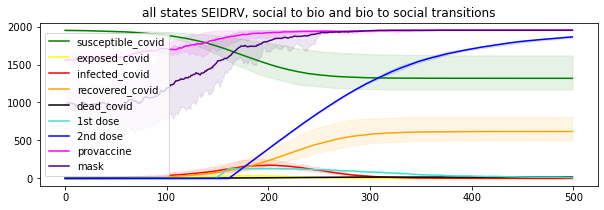

In [9]:
colors = [("green", "susceptible_covid"), ("yellow", "exposed_covid"), ("red", I_name_bio), ("orange", "recovered_covid"), ("black", "dead_covid"), ("turquoise", "1st dose"), ("blue", "2nd dose"), ("magenta", provaccine_name_socio), ("indigo", promask_name_socio)]
age_sizes = [n]
log = sim(10)
plot(log, colors, age_sizes, by_age=False, title=f"SEIDRV, social to bio and bio to social transitions", percent_extremes_remove=0.1)